# LE-SDE Experiments

Jiayao Zhang (Apr 16)

In [1]:
from __future__ import print_function, absolute_import, division

%load_ext autoreload
%autoreload 2
# general imports
import sys, os, json, requests, time, datetime, logging, multiprocessing
from pathlib import Path
import pandas as pd
import numpy as np

In [23]:
# configs for plots
from matplotlib import pyplot as plt
from matplotlib import rc # this is the matplotlib suggestion
import seaborn as sns
sns.set()

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (8., 8.0)
sns.set_style("darkgrid")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette('deep')

In [2]:
def console_log(msg, end='\n'):
    os.write(1, ('[LOG/{}]'.format(multiprocessing.current_process().name)+msg+end).encode('utf-8'))


In [5]:
# env variables to limit CPU/GPU usage
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=
%env OMP_NUM_THREADS=3
%env OPENBLAS_NUM_THREADS=3
%env OPENMP_NUM_THREADS=3
%env MKL_NUM_THREADS=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=
env: OMP_NUM_THREADS=3
env: OPENBLAS_NUM_THREADS=3
env: OPENMP_NUM_THREADS=3
env: MKL_NUM_THREADS=3


In [6]:
import torch
TORCH_DEV = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.is_available()

False

In [7]:
LOCAL_DATA_PATH = Path('/shared/zjiayao/data')

## Dataset Generation

### GeoMNIST

We generate a **GeoMNIST** dataset, which contains images of geometric shapes.
    

In [8]:
import skimage.draw as skd
import scipy.ndimage as simg

In [9]:
def viz_imglist(imgs, figsize=None, figname=None):
    """
    **viz_imglist** shows a list of images
    """
    if figsize is not None:
        plt.figure(figsize=figsize)
    for idx, img in enumerate(imgs):
        plt.subplot(1,len(imgs), idx+1)
        ax = plt.gca()
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    if figname is not None:
        plt.tight_layout()
        plt.savefig(figname, bbox_inches='tight')

In [10]:
class Transform:
    rotation = lambda x, incr : simg.rotate(x, incr, reshape=False)
    shift = lambda x, incr    : simg.shift(x, incr, order=1, mode='nearest')
    gauss = lambda x, sigma   : simg.gaussian_filter(x, sigma=sigma)
    
def pair_shuffle(xs, ys):
    indices = np.arange(0, len(xs))
    np.random.shuffle(indices)
    return xs[indices], ys[indices]

def continue_apply(xs, start, end, func):
    """
    **continue_apply** apply func to xs with linearly interpolation in [start, end]
    """
    N = xs.shape[0]
    incrs = [(end-start) / (1. * N) * i + start for i in range(N)]
    img = [func(xs[i], incrs[i]) for i in range(N)]
    return np.array(img)

def uniform_smp_apply(xs, start, end, func):
    """
    **uniform_smp_apply** apply func to xs with random selection in [start, end]
    """
    N = xs.shape[0]
    incrs = np.random.rand(N)* (end - start) + start
    img = [func(xs[i], incrs[i]) for i in range(N)]
    return np.array(img)



In [11]:
def circle_factory(n, shape, r=10, e=2, dr=1, **kwargs):
    base_img = np.zeros((n, ) + shape)
    for ii, rr in enumerate(np.linspace(r-dr, r+dr, n)):
        idx = skd.ellipse(shape[0]/2, shape[1]/2, rr, rr * e, shape=shape)
        base_img[ii, idx[0], idx[1]] = 1
    return base_img

def square_factory(n, shape, rx=10, ry=15, dr=1, **kwargs):
    base_img = np.zeros((n, ) + shape)
    for ii, rr in enumerate(np.linspace(-dr, dr, n)):
        idx = skd.rectangle((shape[0]/2-rx+rr, shape[1]/2-ry+rr), (shape[0]/2+rx+rr, shape[1]/2+ry+rr), shape=shape)
        base_img[ii, idx[0].astype(int), idx[1].astype(int)] = 1
    return base_img

def triag_factory(n, shape, rx=15, ry=15, dr=1, **kwargs):
    base_img = np.zeros((n, ) + shape)
    cx, cy = shape[0]/2, shape[1] / 2
    for ii, rr in enumerate(np.linspace(-dr, dr, n)):
        idx = skd.polygon([cx+rr, cx+rx+rr, cx-rx+rr], [cy-ry*np.sqrt(3)+rr, cy+ry+rr, cy+ry+rr], shape=shape)
        base_img[ii, idx[0].astype(int), idx[1].astype(int)] = 1
    return base_img

def build_data(n, shape, label, **kwargs):
    label2fact = {
        'circle'   : circle_factory,
        'square'   : square_factory,
        'triangle' : triag_factory,
    }
    if not label.lower() in label2fact.keys():
        raise Exception(f"Label class {label} not found.")
    factory = label2fact[label.lower()]
    dat = factory(n=n, shape=shape, **kwargs)
    dat = continue_apply(dat, 0, 176, Transform.rotation)
    dat = uniform_smp_apply(dat, 0.9, 1.1, Transform.gauss)
    return dat

In [21]:
def gen_geomnist_data(n_tr, n_val, data_shape):
    n_smp_per_cls = n_tr + n_val
    n_classes = 3
    
    circle = build_data(n_smp_per_cls, data_shape, 'circle', r=6)
    square = build_data(n_smp_per_cls, data_shape, 'square', rx=4, ry=8)
    triangle = build_data(n_smp_per_cls, data_shape, 'triangle', rx=10, ry=8)
    
    np.random.shuffle(circle)
    np.random.shuffle(square)
    np.random.shuffle(triangle)
    
    Xtr = np.vstack([triangle[:n_tr], square[:n_tr], circle[:n_tr]])
    Ytr = np.array([0] * n_tr + [1] * n_tr + [2] * n_tr)
    Ytr = np.repeat(np.arange(n_classes), n_tr) 
    Xval = np.vstack([triangle[n_tr:n_tr+n_val], square[n_tr:n_tr+n_val], circle[n_tr:n_tr+n_val]])
    Yval = np.repeat(np.arange(n_classes), n_val) 

    geomnist_data = [Xtr, Ytr, Xval, Yval]
    
    return n_smp_per_cls, n_classes, geomnist_data

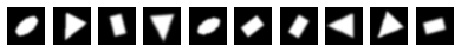

In [24]:
viz_imglist(gen_geomnist_data(800, 200, (32, 32))[-1][0][np.random.choice(2400, 10)])

### CIFAR10

In [12]:
def load_cifar10():
    import torchvision
    import torchvision.transforms as transforms
    transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    return torchvision.datasets.CIFAR10(root=str(LOCAL_DATA_PATH/'vision'), train=True, download=True, transform=transform), torchvision.datasets.CIFAR10(root=str(LOCAL_DATA_PATH/'vision'), train=False, download=True, transform=transform)

In [13]:
CIFAR10 = load_cifar10()
cifar10_tr = list(CIFAR10[0])
cifar10_va = list(CIFAR10[1])

Files already downloaded and verified
Files already downloaded and verified


In [14]:
def cifar_unpack(dt=cifar10_tr, clss=None):
    xs = torch.stack([xx[0] for xx in dt])
    ys = np.array([xx[1] for xx in dt])
    if clss is not None:
        sel = np.zeros(ys.shape)
        for cr in cls:
            sel |= (sel == cr)
        xs = xs[sel]
        ys = ys[sel]
    return xs, ys



In [15]:
cifar10_xtr, cifar10_ytr = cifar_unpack(cifar10_tr)
cifar10_xva, cifar10_yva = cifar_unpack(cifar10_va)
cifar10_all = [cifar10_xtr, cifar10_ytr, cifar10_xva, cifar10_yva]

cifar10_n_tot_tr = 5000 # training samples per class available in the dataset
cifar10_n_tot_va = 1000

In [19]:
def get_random_smps(x_tr, y_tr, x_va, y_va, n_tr, n_va, n_c=3, n_tot_tr=cifar10_n_tot_tr, n_tot_va=cifar10_n_tot_va):
    """
    generate random samples
    """
    tridxs = [np.random.choice(n_tot_tr, n_tr) for _ in range(n_c)]
    vaidxs = [np.random.choice(n_tot_va, n_va) for _ in range(n_c)]
    Xtr = torch.vstack([cifar10_xtr[cifar10_ytr==k][tridxs[k]] for k in range(n_c)])
    Ytr = np.repeat(np.arange(n_c), n_tr) 
    Xva = torch.vstack([cifar10_xva[cifar10_yva==k][vaidxs[k]] for k in range(n_c)])
    Yva = np.repeat(np.arange(n_c), n_va) 
    
    return Xtr, Ytr, Xva, Yva

# Define Models

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [26]:
class SimpleConv(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(SimpleConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class SimpleConv3d(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(SimpleConv3d, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [27]:
def gen_model(n_classes, lr=0.005, model_func=SimpleConv):
    model = model_func(input_shape=data_shape, n_classes=n_classes).double()
    loss_func = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0)
    return model, loss_func, opt

# Training

In [28]:
def train(data_set, n_trials, n_iters, save_file, lr, data_name='geomnist', verbose=True, last_n_trial=0, model_kws={}):
    
    save_times = np.linspace(last_n_trial,last_n_trial+n_trials-1, 5).astype(int)
    
    xtr, ytr, xval, yval = [torch.Tensor(dt).to(TORCH_DEV) for dt in data_set]
    xtr = xtr.double()
    ytr = ytr.long()
    xval = xval.double()
    yval = yval.long()
    n_cls = model_kws['n_classes']
    
    if data_name.lower() == 'geomnist':
        xtr = xtr.view(-1, 1, *data_shape).double()
        xval = xval.view(-1, 1, *data_shape).double()
    
    N_tr = len(xtr)
    N_val = len(xval)
    
    df_cols = ['trial', 'itr', 'smp', 'y', ] + [f'y_logit{i}' for i in range(n_cls)] + ['tr_loss', 'val_loss', 'val_acc']
    history = pd.DataFrame(columns=df_cols)

    for nt in range(last_n_trial,last_n_trial+n_trials):
        if verbose:
            tqdmr = tqdm.tqdm(range(n_iters))
        else:
            tqdmr = range(n_iters)
            
        model, loss_func, opt = gen_model(**model_kws)
        model.to(TORCH_DEV)
        
        for it in tqdmr:
            
            smp_idx = np.random.choice(N_tr, 1)
            xx = xtr[smp_idx]
            yy = ytr[smp_idx]

            model.train()
            ypred = model(xx)
            loss = loss_func(ypred, yy)
            tr_loss = loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()

            model.eval()
            with torch.no_grad():
                model_out = model(xval)
                val_ls = (loss_func(model_out, yval) * xval.shape[0]).item()
                cor = torch.sum(torch.max(model_out,-1)[1] == yval).item()
            val_loss = val_ls / N_val
            val_acc = cor / N_val

            history = history.append(pd.DataFrame([[nt, it, smp_idx[0], yy.item(), 
                                                    *[ypred[0][c].item() for c in range(n_cls)],
                                                    tr_loss, val_loss, val_acc]], columns=df_cols))

            if verbose:
                tqdmr.set_description(f"Itr: {it:03d} Smp: {smp_idx[0]:05d} tr_loss: {tr_loss:.2f} val_acc: {val_acc:.2f} val_loss: {val_loss:.3f}")
                tqdmr.refresh()
            else:
                if it % 500 == 0:
                    console_log(f"Itr: {it:03d} Smp: {smp_idx[0]:05d} tr_loss: {tr_loss:.2f} val_acc: {val_acc:.2f} val_loss: {val_loss:.3f}")
        if nt in save_times:
            history.to_csv(save_file, header=True, index=None)
            
    history.to_csv(save_file, header=True, index=None)



### GeoMNIST

Training on GeoMNIST dataset, varying sample size $n$.

In [ ]:
smp_cfg = [(40,10), (80,20), (240, 60), (480, 120), (800, 200), (2400, 600), (4800, 1200)]

n_iters = 10000
n_trials = 100
lr = 0.005
data_shape = (32, 32)

In [ ]:
for idx, (n_tr, n_val) in enumerate(smp_cfg):
    n_smp_per_cls, n_classes, geomnist_data = gen_geomnist_data(n_tr, n_val, data_shape)
    save_file = f'./exp_data/geom_K3_m{int(n_smp_per_cls)}_it10k_l{lr}.csv'
    console_log(f"[{idx:3d}] {n_smp_per_cls} smps, save to {save_file}")
    
    train(geomnist_data, n_trials, n_iters, save_file, lr, data_name='geomnist', verbose=False, model_kws={'lr': lr, 'model_func':SimpleConv, 'n_classes':n_classes})

    


### CIFAR10

Training on CIFAR10, varying number of classes, $K$.

In [25]:
smp_cfg = [2, 3, 4, 5, 6, 7, 8, 9, 10]

n_iters = 30000
n_trials = 50
lr = 0.001
data_shape = (32, 32)

n_tr=2000      # how many training samples per class
n_val=500      # how many validation samples per class
n_smp_per_cls = n_tr + n_val

In [ ]:
for idx, n_cls in enumerate(smp_cfg):
    CIFAR_data = get_random_smps(*cifar10_all, n_tr=n_tr, n_va=n_val, n_c=n_cls)
    save_file = f'./exp_data/cifar10_K{n_cls}_m{int(n_smp_per_cls)}_it30k_l{lr}.csv'
    console_log(f"[{idx:3d}] {n_smp_per_cls} smps, save to {save_file}")
    
    train(CIFAR_data, n_trials, n_iters, save_file, lr, verbose=False, model_kws={'lr': lr, 'model_func':SimpleConv3d, 'n_classes':n_cls})

    
